In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


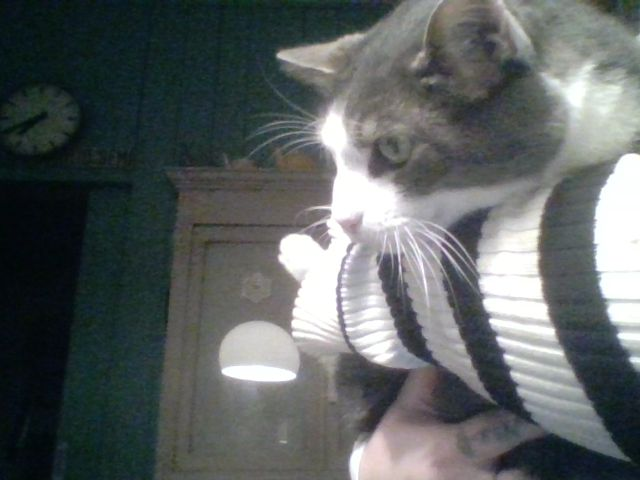

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
%%capture
!pip install ultralytics

In [ ]:
class Worker:
    def __init__(self, im,):
        xc=im.shape[1]//2
        yc=im.shape[0]//2
        self.im = im
        self.im_draw = im.copy()
        s= 100
        self.x1 = xc-s
        self.y1 = yc-s
        self.x2 = xc+s
        self.y2 = yc+s
    def inside_outside(self,x,y):
        cv2.rectangle(self.im_draw, (self.x1,self.y1), (self.x2,self.y2), (255,255,0), 1)
        cv2.circle(self.im_draw, (x,y), 5, (0,255,0), -1)
        if (self.x1<=x<=self.x2) and (self.y1<=y<=self.y2):
            return True
        else:
            return False




0: 480x640 (no detections), 194.4ms
Speed: 3.0ms preprocess, 194.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


array([[[ 3, 13, 14],
        [ 3, 13, 14],
        [ 4, 14, 16],
        ...,
        [52, 73, 56],
        [53, 74, 59],
        [54, 77, 61]],

       [[ 5, 15, 16],
        [ 6, 16, 17],
        [ 6, 16, 18],
        ...,
        [54, 75, 60],
        [55, 78, 62],
        [58, 81, 65]],

       [[ 8, 18, 17],
        [ 8, 18, 17],
        [ 7, 17, 18],
        ...,
        [56, 77, 62],
        [57, 79, 66],
        [60, 84, 70]],

       ...,

       [[ 5, 13, 26],
        [ 4, 12, 25],
        [ 5, 13, 24],
        ...,
        [14, 24, 36],
        [13, 23, 35],
        [13, 23, 35]],

       [[ 6, 14, 27],
        [ 4, 12, 25],
        [ 4, 12, 23],
        ...,
        [16, 26, 36],
        [15, 25, 35],
        [15, 25, 35]],

       [[ 8, 16, 29],
        [ 5, 13, 26],
        [ 2, 10, 21],
        ...,
        [18, 28, 38],
        [16, 26, 36],
        [16, 26, 36]]], dtype=uint8)
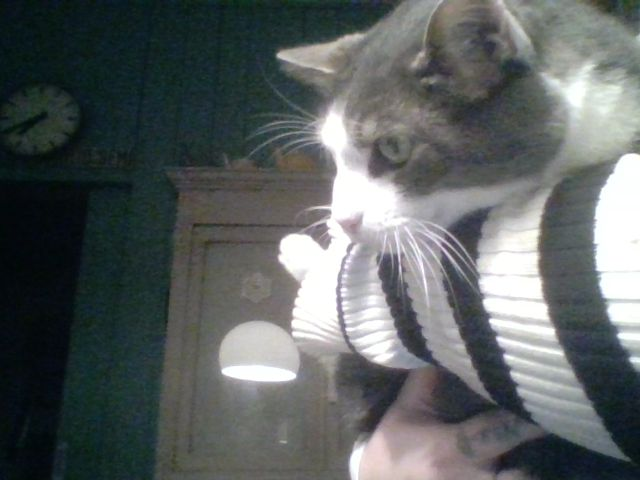

In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
from pydantic import BaseModel

#Reading the image in python
im = cv2.imread("photo.jpg", cv2.IMREAD_COLOR) #BGR
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

#Load the model for doing something
model =YOLO("yolo11n-pose.pt") #n,s,m,l,x

class GetKeypoint(BaseModel):
    NOSE:           int = 0
    LEFT_EYE:       int = 1
    RIGHT_EYE:      int = 2
    LEFT_EAR:       int = 3
    RIGHT_EAR:      int = 4
    LEFT_SHOULDER:  int = 5
    RIGHT_SHOULDER: int = 6
    LEFT_ELBOW:     int = 7
    RIGHT_ELBOW:    int = 8
    LEFT_WRIST:     int = 9
    RIGHT_WRIST:    int = 10
    LEFT_HIP:       int = 11
    RIGHT_HIP:      int = 12
    LEFT_KNEE:      int = 13
    RIGHT_KNEE:     int = 14
    LEFT_ANKLE:     int = 15
    RIGHT_ANKLE:    int = 16

#pridiction
results = model.predict(im)

#Iterate oover the images
for result in results:

    # is there a person in the image
    for i in range(0, len(result.boxes)):
        x,y,w,h = result.boxes.xyxy.cpu().numpy()[i]
        id = result.boxes.cls.cpu().numpy()[i]
        score = result.boxes.conf.cpu().numpy()[i]
        cv2.putText(im, f"{result.names[id]}:{score}", (int(x),int(y-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.rectangle(im, (int(x),int(y)), (int(w),int(h)), (0,255,0), 2)
        NOSE = result.keypoints.xy.cpu().numpy()[i][0].astype(np.int32)
        LEFT_EYE = result.keypoints.xy.cpu().numpy()[i][1].astype(np.int32)
        RIGHT_EYE = result.keypoints.xy.cpu().numpy()[i][2].astype(np.int32)
        LEFT_EAR = result.keypoints.xy.cpu().numpy()[i][3].astype(np.int32)
        RIGHT_EAR = result.keypoints.xy.cpu().numpy()[i][4].astype(np.int32)
                #LEFT_SHOULDER = result.keypoints.xy.cpu().numpy()[i][5].astype(np.int32)
                #RIGHT_SHOULDER = result.keypoints.xy.cpu().numpy()[i][6].astype(np.int32)
                #LEFT_ELBOW = result.keypoints.xy.cpu().numpy()[i][7].astype(np.int32)
                #RIGHT_ELBOW = result.keypoints.xy.cpu().numpy()[i][8].astype(np.int32)
                #LEFT_WRIST = result.keypoints.xy.cpu().numpy()[i][9].astype(np.int32)
                #RIGHT_WRIST = result.keypoints.xy.cpu().numpy()[i][10].astype(np.int32)
                #LEFT_HIP = result.keypoints.xy.cpu()[i].numpy()[11].astype(np.int32)
                #RIGHT_HIP = result.keypoints.xy.cpu()[i].numpy()[12].astype(np.int32)
                #LEFT_KNEE = result.keypoints.xy.cpu()[i].numpy()[13].astype(np.int32)
                #RIGHT_KNEE= result.keypoints.xy.cpu()[i].numpy()[14].astype(np.int32)
                #LEFT_ANKLE = result.keypoints.xy.cpu()[i].numpy()[15].astype(np.int32)
                #RIGHT_ANKLE = result.keypoints.xy.cpu()[i].numpy()[16].astype(np.int32)

        #now we see if the nose, eyes, ears are inside the box that we created with the class worker

        w = Worker(im)
        res_nose = w.inside_outside(NOSE[0],NOSE[1])
        #res_earl = w.inside_outside(LEFT_EAR[0],LEFT_EAR[1])
        #res_earr = w.inside_outside(RIGHT_EAR[0],RIGHT_EAR[1])
        res_eyel = w.inside_outside(LEFT_EYE[0],LEFT_EYE[1])
        res_eyer = w.inside_outside(RIGHT_EYE[0],RIGHT_EYE[1])
        if res_nose and res_eyel and res_eyer:
            print("Focused!")
        else:
            print("Please, Focus!")



        #cv2.circle(im, ((NOSE[0]),(NOSE[1])), 5, (0,0,255), -1)
        #cv2.circle(im, ((LEFT_EYE[0]),(LEFT_EYE[1])), 5, (0,0,255), -1)
        #cv2.circle(im, ((RIGHT_EYE[0]),(RIGHT_EYE[1])), 5, (0,0,255), -1)
        #cv2.circle(im, ((LEFT_EAR[0]),(LEFT_EAR[1])), 5, (0,0,255), -1)
        #cv2.circle(im, ((RIGHT_EAR[0]),(RIGHT_EAR[1])), 5, (0,0,255), -1)
        #cv2.rectangle(im, (Worker.x1,Worker.y1), (self.x2,self.y2), (255,255,0), 1)



    display(im)
    break



#visualise
#display(res[0].plot())
#display (im)